This notebook tries to recreate plots from Sky Model papers with my model

In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, glob, sys
from astropy.io import fits
import astropy.table
import pandas as pd
import astropy.units as u

In [2]:
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('large')

In [3]:
sys.path.insert(0,'/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/')

In [21]:
wavelength = np.linspace(3550, 9850, (9850-3550)*10)*u.Angstrom
sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
area = 1 * u.arcsec ** 2

In [5]:
import sky_model

In [9]:
ObsMeta = astropy.table.Table(np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/test_ObsMeta.npy'))

In [16]:
Model = sky_model.SkyModel(ObsMeta)

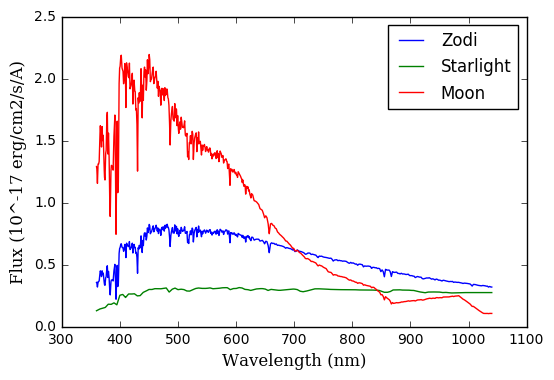

In [17]:
model_wave, cont_model = Model.run_model(plot=True)

(360, 630)

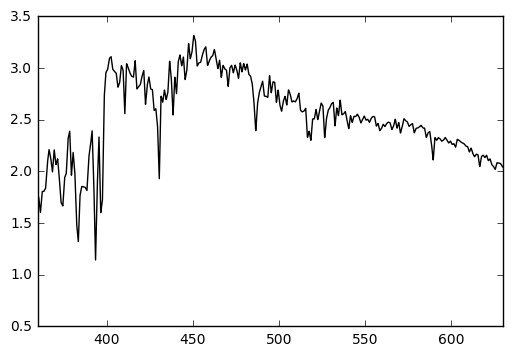

In [18]:
plt.plot(model_wave, cont_model, 'k-')
plt.xlim(360,630)

## Transmission

I'm really only going to use the kpnoextinct.dat curve

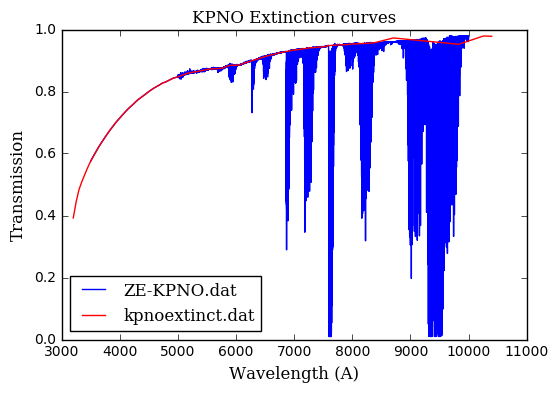

In [36]:
ext_f1 = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/files/kpnoextinct.dat'
ext_f2 = '/Users/parkerf/Research/SkyModel/BOSS_Sky/Model/files/ZenithExtinction-KPNO.dat'

ext1 = astropy.table.Table(np.genfromtxt(ext_f1), names=('WAVE','EXT'))
ext2 = astropy.table.Table(np.loadtxt(ext_f2), names = ('WAVE', 'EXT'))

plt.plot(ext2['WAVE'], 10**(-0.4*ext2['EXT']), '-', label = 'ZE-KPNO.dat')
plt.plot(ext1['WAVE'], 10**(-0.4*ext1['EXT']), 'r-', label = 'kpnoextinct.dat')
plt.title("KPNO Extinction curves",fontproperties=font)
plt.xlabel("Wavelength (A)",fontproperties=font)
plt.ylabel('Transmission',fontproperties=font)
plt.legend(loc = 'lower left', prop=font)

I've also tried to model up the Rayleigh and Aerosol (Mie) absorption as well. Molecular absorption curves are missing and will likely require radiative transfer calculations. Note: absorption depends on time of year and airmass

In [24]:
airmass = 1.

In [25]:
R = Model.ISL.rayleigh_trans(wave_um, airmass)
M = Model.ISL.mie_trans(wave_um, airmass)

(360, 1000)

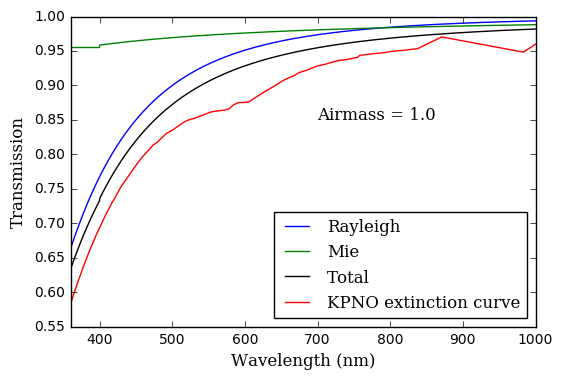

In [32]:
#plt.title("Fig. 2 Noll et al")
plt.plot(wave, R, label='Rayleigh')
plt.plot(wave, M, label='Mie')
plt.plot(wave, R*M, 'k', label = 'Total')
plt.plot(wave, Model.ISL.ext(wave), label = 'KPNO extinction curve')
#plt.title("Transmission curves",fontproperties=font)
plt.text(700,0.85,'Airmass = 1.0',fontproperties = font)
plt.xlabel("Wavelength (nm)",fontproperties=font)
plt.ylabel('Transmission',fontproperties=font)
plt.legend(loc=4,prop=font)
plt.xlim([360,1000])

## Zodiacal Redenning

We use a solar spectrum and divide by the value at 500nm to get the absolute spectrum. Then we add a redenning law. This probably doesn't matter too much for optical measurements

In [9]:
f_abs = Model.Zodi.relative_sun_flux
f_co_90 = Model.Zodi.f_co(90, Model.Zodi.sun_wave)
f_co_30 = Model.Zodi.f_co(30, Model.Zodi.sun_wave)

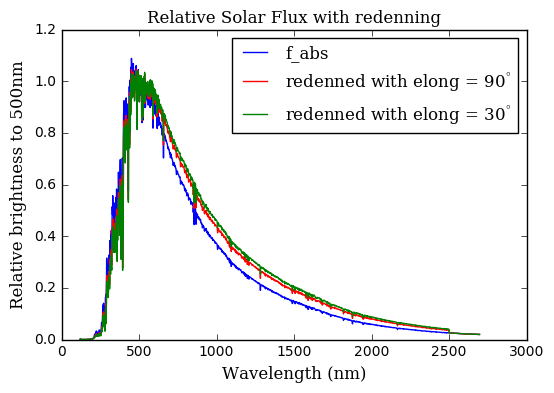

In [10]:
plt.plot(Model.Zodi.sun_wave, f_abs, label = "f_abs")
plt.plot(Model.Zodi.sun_wave, f_abs*f_co_90, 'r', label = "redenned with elong = 90$^{\degree}$")
plt.plot(Model.Zodi.sun_wave, f_abs*f_co_30, 'g', label = "redenned with elong = 30$^{\degree}$")
plt.title("Relative Solar Flux with redenning", fontproperties = font)
plt.xlabel("Wavelength (nm)", fontproperties = font)
plt.ylabel("Relative brightness to 500nm", fontproperties = font)
plt.legend(prop=font)

## Zodiacal Transmission/Scattering

In [17]:
sun_sep = Model.Zodi.sun_sep(Model.moon_alt, Model.moon_sep, Model.moon_sun_sep, Model.sun_alt)
above_atm = Model.Zodi.get_zodi(Model.ecl_lat, Model.ecl_lon, Model.sun_lon, sun_sep, wave)

In [19]:
total = Model.Zodi.zodi_spectrum(Model.ecl_lat, Model.ecl_lon, Model.sun_lon, Model.airmass, Model.moon_alt, Model.moon_sep, Model.moon_sun_sep, Model.sun_alt, wave)

In [20]:
trans = Model.Zodi.Zodi_transmitted

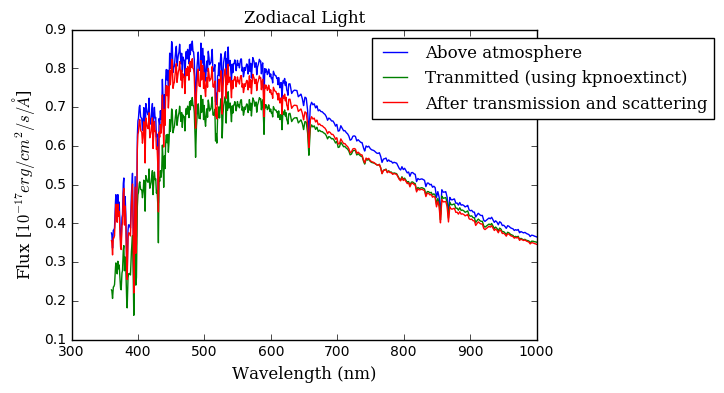

In [21]:
plt.plot(wave, above_atm, label = 'Above atmosphere')
plt.plot(wave, trans, label = 'Tranmitted (using kpnoextinct)')
plt.plot(wave, total, label = 'After transmission and scattering')
plt.title("Zodiacal Light",fontproperties=font)
plt.xlabel('Wavelength (nm)', fontproperties=font)
plt.ylabel('Flux [$10^{-17} erg/cm^{2}/s/\AA$]', fontproperties=font)
plt.legend(prop=font,bbox_to_anchor=[1.4,1])

## ISL Scattered Flux

Actually, the scattering in my model is just the extinciton curve. It would be better to run a scattering code, which will likely scatter more light into the line of sight in some places. I also haven't included the Melchior increase of ~16%.

In [22]:
above_atm = Model.ISL.get_isl(Model.gal_lat, Model.gal_lon, wave)

In [23]:
scattered = Model.ISL.isl_spectrum(Model.gal_lat, Model.gal_lon, wave, Model.airmass)

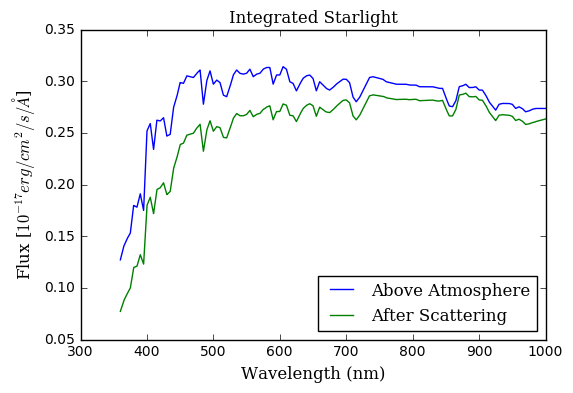

In [24]:
plt.plot(wave, above_atm, label = "Above Atmosphere")
plt.plot(wave, scattered, label = "After Scattering")
plt.title("Integrated Starlight",fontproperties = font)
plt.xlabel("Wavelength (nm)",fontproperties = font)
plt.ylabel("Flux [$10^{-17} erg/cm^{2}/s/\AA$]",fontproperties = font)
plt.legend(loc=4,prop=font)

## Scattered Moonlight

In [43]:
moon_alt = np.linspace(0, 80, 8)

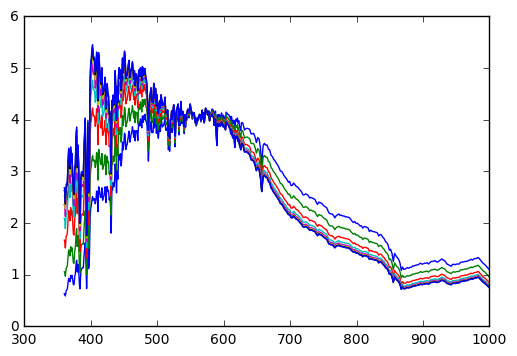

In [44]:
for alt in moon_alt:
    moon = Model.Moon.moon_spectrum(Model.moon_dist, alt, Model.moon_sep, Model.days2full, Model.solar_seleno, Model.airmass, wave)
    plt.plot(wave, moon, label = alt)

In [49]:
days2full = np.linspace(0,29,29)

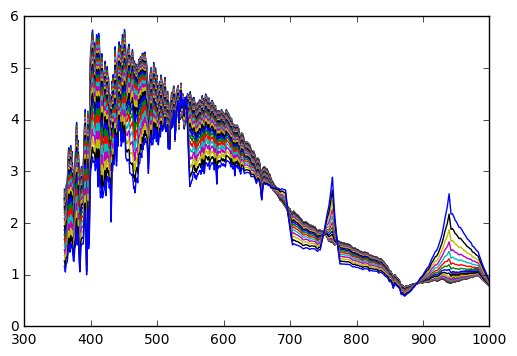

In [50]:
for day in days2full:
    moon = Model.Moon.moon_spectrum(Model.moon_dist, Model.moon_alt, Model.moon_sep, day, Model.solar_seleno, Model.airmass, wave)
    plt.plot(wave, moon, label = alt)

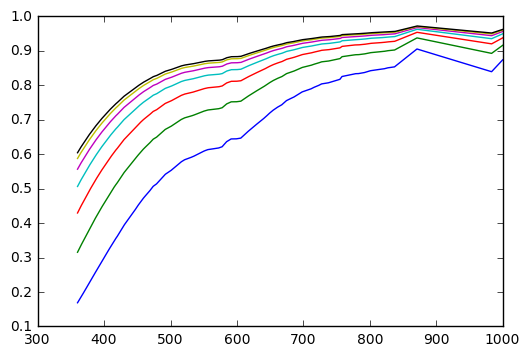

In [48]:
moon_alt = np.linspace(0, 80, 8)
for alt in moon_alt:
    if alt > 0:
        Zmoon = np.deg2rad(90-alt)
        Xmoon = (1-0.96*(np.sin(Zmoon))**(2))**(-0.5)
        moon_ext = Model.Moon.get_extinction_curve(Xmoon, wave)
        plt.plot(wave, moon_ext, label = alt)

## Scattering

Need to code up scattering equation for two different phase functions. I0 is the extinction curve.

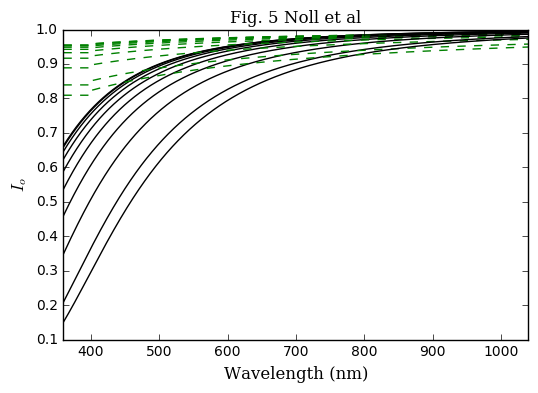

In [15]:
zeniths = [0,10,20,30,40,50,60,70,80,85]
for z in zeniths:
    airmass = (1-0.96*(np.sin(np.deg2rad(z)))**(2))**(-0.5)
    mie = Model.ISL.mie_trans(wave_um, airmass)
    ray = Model.ISL.rayleigh_trans(wave_um, airmass)
    plt.plot(wave, ray, 'k-')
    plt.plot(wave,mie, 'g--')
plt.xlim([360,1040])
plt.xlabel("Wavelength (nm)",fontproperties=font)
plt.ylabel('$I_{o}$',fontproperties=font)
plt.title("Fig. 5 Noll et al",fontproperties=font)

In [9]:
nm_500 = [np.abs(500.-w) for w in wave]
nm_id = np.argmin(nm_500)

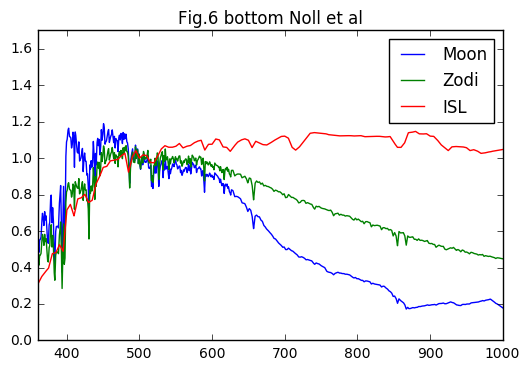

In [10]:
elements = {'Zodi':Model.zz,'ISL':Model.isl,'Moon':Model.moon}
plt.figure()
for name, element in elements.items():
    standard = element[nm_id]
    stand_flux = element/(np.ones(len(wave))*standard)
    plt.plot(wave,stand_flux, label = name)
plt.xlim([360,1000])
plt.ylim([0,1.7])
plt.legend()
plt.title("Fig.6 bottom Noll et al")

Above atmosphere brightnesses

In [12]:
zodi = Model.Zodi.get_zodi(Model.ecl_lat, Model.ecl_lon, Model.sun_lon, Model.sun_sep, wave)
moon = Model.Moon.get_moon(Model.moon_dist, Model.lunar_phase, Model.solar_seleno, wave)
isl = Model.ISL.get_isl(Model.gal_lat, Model.gal_lon, wave)

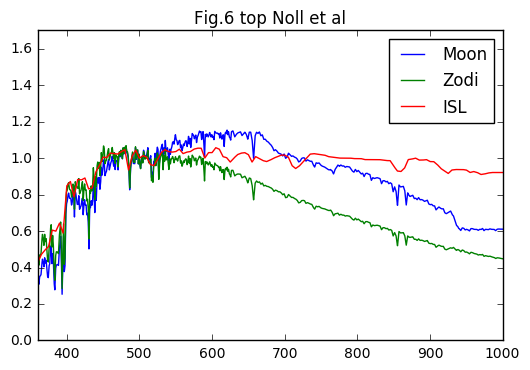

In [13]:
elements = {'Zodi':zodi, 'ISL':isl,'Moon':moon}
plt.figure()
for name, element in elements.items():
    standard = element[nm_id]
    stand_flux = element/(np.ones(len(wave))*standard)
    plt.plot(wave,stand_flux, label = name)
plt.xlim([360,1000])
plt.ylim([0,1.7])
plt.legend()
plt.title("Fig.6 top Noll et al")

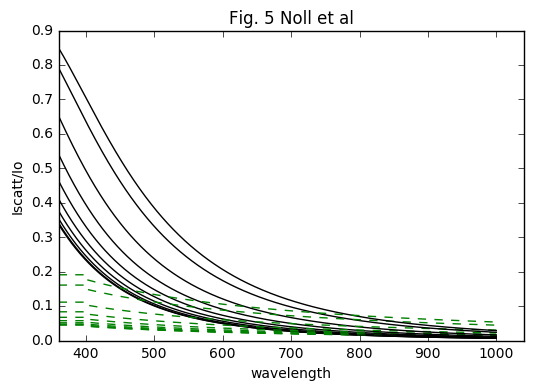

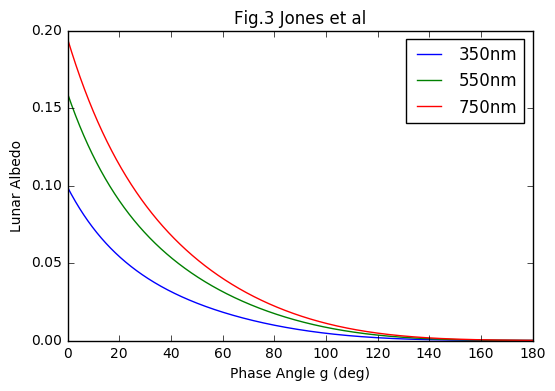

In [18]:
#Albedo plots
waves = [350,550,750]
for w in waves:
    lunar = []
    gs = np.linspace(0,180,1800)
    for g in gs:
        g = np.deg2rad(g)
        alb = moon.albedo(g, np.deg2rad(10.), np.array(w))
        lunar.append(alb)
    plt.plot(gs,lunar,label='%dnm'%w)
plt.title("Fig.3 Jones et al")
plt.xlabel('Phase Angle g (deg)')
plt.ylabel('Lunar Albedo')
plt.legend()
plt.savefig('jonesfig3.png')

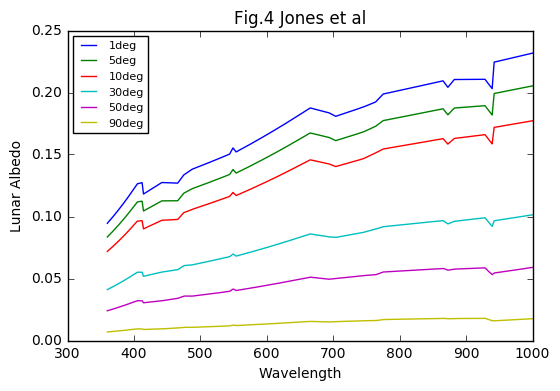

In [19]:
plt.figure()
gs = [1,5,10,30,50,90]
for g in gs:
    alb = moon.albedo(np.deg2rad(g), np.deg2rad(10.), waver)
    plt.plot(waver,alb,label='%ddeg'%g)
plt.title("Fig.4 Jones et al")
plt.xlabel('Wavelength')
plt.ylabel('Lunar Albedo')
plt.legend(loc=2,prop={'size':8})
plt.savefig('jonesfig4.png')

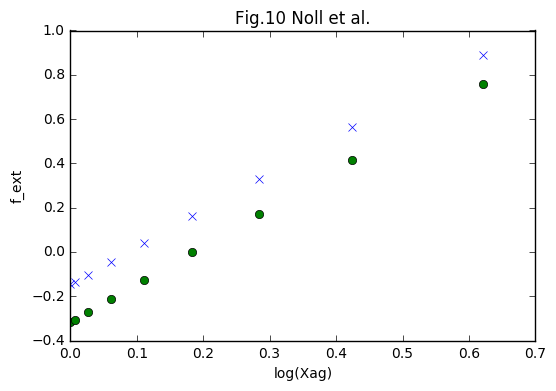

In [20]:
plt.figure()
zs = [0,10,20,30,40,50,60,70,80]
for z in zs:
    alt = 90-z
    Xag = (1-0.972*np.sin(np.deg2rad(z))**2.)**(-0.5)
    fR = airglow.f_R(Xag)
    fM = airglow.f_M(Xag)
    plt.plot(np.log10(Xag),fR,'bx',label = 'Rayleigh')
    plt.plot(np.log10(Xag),fM,'go',label = 'Mie')
plt.title("Fig.10 Noll et al.")
plt.xlabel('log(Xag)')
plt.ylabel('f_ext')

### Full Sky Model

In [9]:
Model.test_run(wave)
composite = Model.combined_model(cont=False)

Running the model with the 'Demo Run' parameters in Noll et al


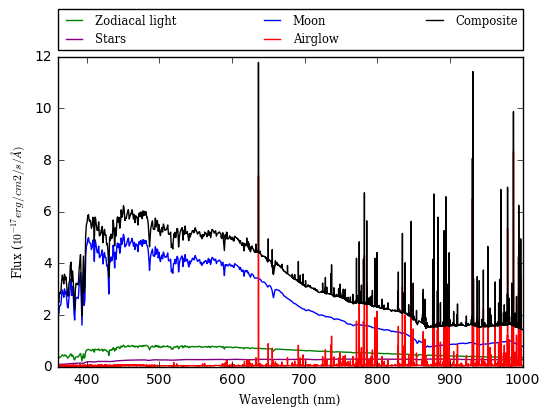

In [58]:
plt.figure()
plt.plot(wave,Model.zz,'g-',label='Zodiacal light')
plt.plot(wave,Model.isl,'purple',label='Stars')
plt.plot(wave,Model.moon,'b-',label='Moon')
plt.plot(wave,Model.ag,'r-',label='Airglow')
plt.plot(wave,composite,'k-',label='Composite')
plt.xlim([360,1000])
plt.xlabel('Wavelength (nm)',fontproperties=font)
plt.ylabel('Flux ($10^{-17} erg/cm2/s/\AA)$',fontproperties=font)
#plt.title('Sky Model',fontproperties=font)
font.set_size('small')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode='expand', borderaxespad=0.,prop=font)
#plt.legend(bbox_to_anchor=[1.4,1],prop=font)

In [49]:
#convert to radiance
#10^-9 erg/s/cm2/A/sr = 10^-8 W/m2/um/sr
def convert():
    sr = 4.25*10**(10) #arcsec^2
    fiber_area = np.pi #arcsec^2  
    convert = 1/(1000000000*(fiber_area/sr))
    return convert

(360, 1000)

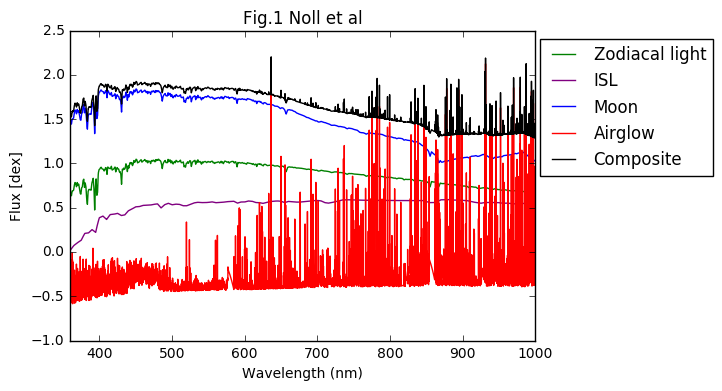

In [50]:
plt.figure()
plt.plot(wave,np.log10(Model.zz*convert()),'g-',label='Zodiacal light')
plt.plot(wave,np.log10(Model.isl*convert()),'purple',label='ISL')
plt.plot(wave,np.log10(Model.moon*convert()),'b-',label='Moon')
plt.plot(wave,np.log10(Model.ag*convert()),'r-',label='Airglow')
plt.plot(wave,np.log10(composite*convert()),'k-',label='Composite')
plt.xlim([360,1040])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux [dex]')
plt.title('Fig.1 Noll et al')
plt.legend(bbox_to_anchor=[1.4,1])
plt.xlim([360,1000])

## Try to compare it to real data

In [25]:
DIR = '/Users/parkerf/Research/BOSS_Sky/flux_repo/SkyModelling'

In [26]:
SPECTRA_DIR = DIR+'/sigma_sky_flux/'
spectra_files = glob.glob(SPECTRA_DIR+'*.npy')

In [27]:
spectra = np.load(DIR+'/6676_calibrated_sky.npy')

In [28]:
meta_data = np.load(DIR+'/meta_rich.npy')

In [29]:
np.unique(meta_data.PLATE)

array([3659, 3975, 4505, 5731, 5798, 5802, 6032, 6277, 6676, 7258], dtype=int32)

In [30]:
this_meta = meta_data[meta_data['PLATE'] == int(6676)]

In [31]:
red_meta = this_meta[this_meta['CAMERAS'] == b'r1'][0]
blue_meta = this_meta[this_meta['CAMERAS'] == b'b1'][0]

In [32]:
blue_meta.dtype

dtype((numpy.record, [('PLATE', '<i4'), ('SPECNO', '<i4'), ('IMG', '<i4'), ('FIB', '<i4'), ('TAI-BEG', '<f8'), ('TAI-END', '<f8'), ('RA', '<f8'), ('DEC', '<f8'), ('CAMERAS', 'O'), ('AIRMASS', '<f4'), ('ALT', '<f8'), ('AZ', '<f8'), ('EXPTIME', '<f4'), ('SEEING20', '<f4'), ('SEEING50', '<f4'), ('SEEING80', '<f4'), ('AIRTEMP', '<f4'), ('DEWPOINT', '<f4'), ('DUSTA', '<f4'), ('DUSTB', '<f4'), ('WINDD25M', '<f4'), ('WINDS25M', '<f4'), ('GUSTD', '<f4'), ('GUSTS', '<f4'), ('HUMIDITY', '<f4'), ('PRESSURE', '<f4'), ('WINDD', '<f4'), ('WINDS', '<f4'), ('MOON_LAT', '<f4'), ('MOON_LON', '<f4'), ('SUN_LAT', '<f4'), ('SUN_LON', '<f4'), ('MOON_ALT', '<f4'), ('MOON_AZ', '<f4'), ('SUN_ALT', '<f4'), ('SUN_AZ', '<f4'), ('MOON_D', '<f8'), ('MOON_SEP', '<f8'), ('SUN_SEP', '<f8'), ('DAYS2FULL', '<f4'), ('ECL_LAT', '<f4'), ('ECL_LON', '<f4'), ('GAL_LAT', '<f4'), ('GAL_LON', '<f4'), ('AZ_CALC', '<f4'), ('FLI', '<f4'), ('SEASON', '<i4'), ('HOUR', '<i4'), ('SOLARFLUX', '<f4'), ('XFOCAL', '<f8'), ('YFOCAL', '<f8'

In [33]:
airmass = blue_meta['AIRMASS']
alt = blue_meta['ALT']
lunar_phase = blue_meta['SUN_SEP']
moon_sep = blue_meta['MOON_SEP']
moon_alt = blue_meta['MOON_ALT']
moon_dist = blue_meta['MOON_D']
ecl_lon = blue_meta['ECL_LON']
ecl_lat = blue_meta['ECL_LAT']
sun_elong = 30

In [34]:
Z = zodi.scattered_zodi(ecl_lat, ecl_lon, airmass, sun_elong, waver)
star = isl.get_isl_spectrum(ecl_lat, ecl_lon, waver, airmass)
scatt_moon = moon.scatt_moon(moon_sep, airmass, moon_alt, waver, moon_dist, np.deg2rad(lunar_phase), np.deg2rad(10))
AG = airglow.airglow_spectrum(waver,alt,airmass)

composite = np.sum([Z,star,scatt_moon,AG],axis=0)

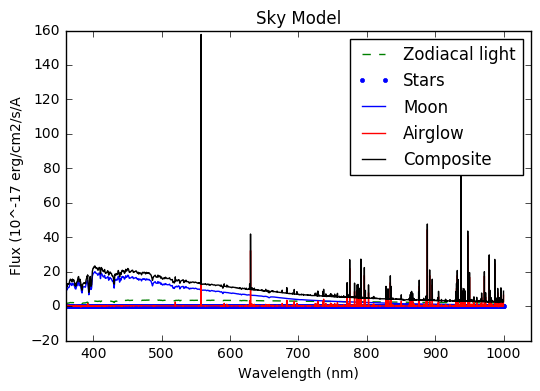

In [35]:
    plt.figure()
    plt.plot(waver,Z,'g--',label='Zodiacal light')
    plt.plot(waver,star,'b.',label='Stars')
    plt.plot(waver,scatt_moon,'b-',label='Moon')
    plt.plot(waver,AG,'r-',label='Airglow')
    plt.plot(waver,composite,'k-',label='Composite')
    plt.xlim([360,1040])
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux (10^-17 erg/cm2/s/A')
    plt.title('Sky Model')
    plt.legend()

In [36]:
def clean_spectra(spectrum):
    """Takes out all nan/inf so lstsq will run smoothly
    """
    ok = np.isfinite(spectrum['SKY'])

    wave = spectrum['WAVE'][ok]
    sky = spectrum['SKY'][ok]
    disp = spectrum['DISP'][ok]
    sigma = spectrum['SIGMA'][ok]
    
    return [wave,sky,sigma,disp]

In [41]:
def air_to_vac(wave):
    """Index of refraction to go from wavelength in air to wavelength in vacuum
    Equation from (Edlen 1966)
    vac_wave = n*air_wave
    """
    #Convert to um
    wave_um = wave*.001
    ohm2 = (1./wave_um)**(2)

    #Calculate index at every wavelength
    nn = []
    for x in ohm2:
        n = 1+10**(-8)*(8342.13 + (2406030/float(130.-x)) + (15997/float(389-x)))
        nn.append(n)
    
    #Get new wavelength by multiplying by index of refraction
    vac_wave = nn*wave
    return vac_wave

In [42]:
blue_wave, blue_sky, blue_sigma, blue_disp = clean_spectra(spectra[blue_meta['SPECNO']])
red_wave, red_sky, red_sigma, red_disp = clean_spectra(spectra[red_meta['SPECNO']])

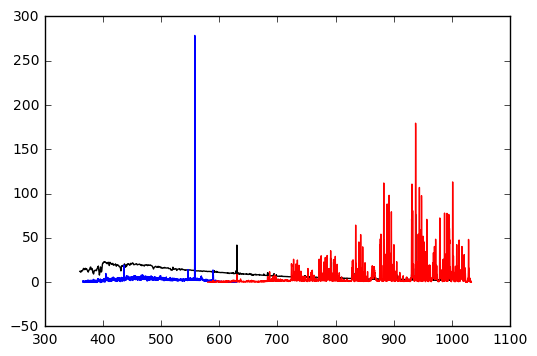

In [45]:
plt.plot(air_to_vac(waver),composite,'k-')
plt.plot(blue_wave, blue_sky, 'b-')
plt.plot(red_wave, red_sky, 'r-')
#plt.xlim([700,850])
#plt.ylim([0,20])